### 랭그래프를 활용한 멀티에이전트 RAG 만들기

하나의 AI 에이전트에게 모든 작업을 맡기는 것보다 각각의 AI 에이전트에게 단순한 업무 단위로 명확하게 지시를 내리고 이를 결합한 워크플로를 만들면  
마치 각 분야의 전문가들이 협업하는 것처럼 시너지를 낼 수 있다.

이런 방식으로 AI 에이전트에게 작업을 분배하고 서로 협력하여 복잡한 작업을 처리하는 시스템을 멀티에이전트라고 한다.

#### RAG의 한계 개선하기

'그렇구나. 잘 찾아왔네. 고마워.' 라고 하거나 '잘 지냈어?' 와 같은 일상적인 질문을 하는 경우에도 만든 RAG는 관련 문서를 찾아와서 답변하므로 시간과 토큰 비용을 낭비한다.

랭그래프를 이용하면 사용자의 질문을 분석해서 RAG를 사용할지 말지 판단하고 RAG가 필요한 경우에만 검색을 사용할 수 있다.  
RAG를 실행할 때에도 필요하지 않는 청크들은 제외하고 답변을 생성하는 등 다양한 작업을 추가할 수 있다.

#### PDF 전처리하고 벡터 DB 만들기

In [2]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

True

In [3]:
# 랭그래프에 기반한 RAG를 구현해보자
from glob import glob 
for g in glob('./data/*.pdf'):
    print(g)

./data/2040_seoul_plan.pdf
./data/OneNYC-2050-Summary.pdf


In [4]:
# read_pdf_and_split_text 함수 만들기
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    """
    주어진 PDF 파일을 읽고 텍스트를 분할합니다.
    매개변수:
        pdf_path (str): PDF 파일의 경로.
        chunk_size (int, 선택적): 각 텍스트 청크의 크기. 기본값은 1000입니다.
        chunk_overlap (int, 선택적): 청크 간의 중첩 크기. 기본값은 100입니다.
    반환값:
        list: 분할된 텍스트 청크의 리스트.
    """
    print(f"PDF: {pdf_path} -----------------------------")

    pdf_loader = PyPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    splits = text_splitter.split_documents(data_from_pdf)
    
    print(f"Number of splits: {len(splits)}\n")
    return splits

In [5]:
# vectorstore 설정하고 청크 처리하기
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import os

##### Vectorstore 설정 #####
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

persist_directory='./chroma_store'

if os.path.exists(persist_directory):
    print("Loading existing Chroma store")
    vectorstore = Chroma(
        persist_directory=persist_directory, 
        embedding_function=embedding
    )
else:
    print("Creating new Chroma store")
    
    vectorstore = None
    for g in glob('./data/*.pdf'):
        chunks = read_pdf_and_split_text(g)
        # 100개씩 나눠서 저장
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=chunks[i:i+100],
                    embedding=embedding,
                    persist_directory=persist_directory
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i+100]
                )

Creating new Chroma store
PDF: ./data/2040_seoul_plan.pdf -----------------------------
Number of splits: 308

PDF: ./data/OneNYC-2050-Summary.pdf -----------------------------
Number of splits: 176



In [7]:
# retrieving
retriever = vectorstore.as_retriever(k=5)
chunks = retriever.invoke("서울시의 환경 정책에 대해 궁금해")

for chunk in chunks:
    print(chunk)
    print('------')

page_content='제4절 기후·환경 부문1. 개요Ÿ기후변화는 21세기에 전 지구적으로 가장 위중한 영향을 미칠 것으로 예상되며, 시민 생활의 모든 측면과 연관되어 있어 향후 서울시의 적극적인 대응이 필요하다.Ÿ탄소중립 목표뿐만 아니라 미세먼지로부터 시민 건강을 지키기 위해서는 건물, 교통, 에너지 등 도시의 주요 인프라 전반의 혁신이 요구되며, 이를 위해 새로운 기술과 혁신적 제도가 필요하다. 제로에너지 건물, 친환경 차량 및 교통 인프라의 확대, 자원·에너지 순환 기반 조성으로 온실가스와 미세먼지 배출량을 획기적으로 감축해야 한다. Ÿ기후변화에 따른 폭염, 풍수해, 도심열섬현상 등 기후재난 및 극한 기후현상이 심해질 것으로 전망되어 보다 능동적인 대비가 필요하다. Ÿ한편, 환경보존과 쾌적한 도시환경을 위해 도심 곳곳 시민 모두가 누릴 수 있는 도심숲과 생활공원 등 녹색공간을 조성하고, 이를 수변 공간과 연계하여 풍부하고 지속가능한 자연환경이 확보될 수 있도록 한다.Ÿ장기적인 측면에서 시민 개개인과 기업 등 다양한 도시 내 행위자의 적극적인 협조가 필수적이며 이를 위해 중앙정부와 서울시 환경계획 담당부서와의 협력적이고 포용적인 거버넌스 체계를 구축하도록 한다.목표 전략3-12050 탄소중립 실현을 위한 도시 인프라 전환3-1-1건물 부문의 탄소배출을 감축하기 위한 친환경 기술 개발 및 적극 적용3-1-2미래 모빌리티 기술 활용과 친환경 수송 차량 및 관련 인프라 확충3-1-3에너지 전환을 위한 청정에너지 기반 구축3-1-4대기 환경을 고려한 공간계획과 배출원 관리체계 강화3-2건강한 순환도시 조성을 위한자립적인 자원순환 체계 구축3-2-1자원순환·관리 자립을 위한 분산형 폐기물처리 시설 구축3-2-2기후 행동 포용적 거버넌스 구축을 위한 시민 행동 활성화3-3사람과 자연의 공존을 위한친환경 생태도시 구축3-3-1건물 에너지 분야 효율성 개선 및 도심 속 생물 다양성 확보3-3-2지속가능한 통합 물순환 체계 구축3-4다양한 수변을 경험할 수 있는수변감성도

In [8]:
# 언어 모델 설정하기
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke("안녕?")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5ASSucTP6cPlZwOZSBonsdJ6tpHx', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--253f53aa-4de7-4406-9d3b-542db6e5c516-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### 챗봇에 라우터 설정하기

GPT와 같은 언어 모델이 사용자의 입력을 일상적인 대화인지 RAG가 필요한 질문인지 판단하는 기능을 구현해 보자.

일상적인 대화라면 casual_talk를 반환하고  
RAG가 필요하면 vector_store를 반환

이 판단에 따라 conditional_edge를 이용해 어떤 노드를 활용할지를 판단하게 된다.

In [9]:
# 라우터 설정하기
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal # 문자열 리터럴 타입을 지원하는 typing 모듈의 클래스
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅합니다."""
    
    datasource: Literal["vectorstore", "casual_talk"] = Field(
        ...,
        description="""
        사용자 질문에 따라 casual_talk 또는 vectorstore로 라우팅합니다.
        - casual_talk: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 때 사용합니다.
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.
        """,
    )

In [10]:
# 사용자 질문 받고 판단하기
# 특정 모델을 structured output (구조화된 출력)과 함께 사용하기 위해 설정
structured_llm_router = model.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk으로 라우팅하는 전문가입니다.
- vectorstore에는 서울, 뉴욕의 발전계획과 관련된 문서가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화에 관련된 경우 casual_talk을 사용하십시오.
"""

# 시스템 메시지와 사용자의 질문을 포함하는 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system),
    ("human", "{question}"),
])

# 라우터 프롬프트와 구조화된 출력 모델을 결합한 객체
question_router = route_prompt | structured_llm_router

In [11]:
# 코드 동작 테스트
print(
    question_router.invoke({
        "question": "서울 온실가스 저감 계획은 무엇인가요?"
    })
)


datasource='vectorstore'


In [12]:
# 코드 동작 테스트
print(question_router.invoke({"question": "잘 지냈어?"}))

datasource='casual_talk'


#### 랭그래프로 RAG에이전트 만들기

관련 있는 청크만 필터링하기

리트리버는 벡터 DB에서 유사도를 기준으로 가장 관련있는 문서를 가져오는데, 질문과 관련 없는 청크를 포함하는 경우 답변을 생성할 때 혼란을 일으킬 수 있으므로 미리 삭제하는 편이 좋다.

문서의 관련성을 판단하는 방법을 프롬프트로 작성하고, 판단 결과는 BaseModel과 .with_structured_output을 활용해 출력 형식을 제한해 보겠다.

In [13]:
# BaseModel을 사용해 출력 방식을 yes 또는 no로 제한하는 GradeDocuments 클래스 정의
# GPT 모델을 그대로 쓰지 않고, .with_structured_output을 사용해 출력 형식을 제한한 structured_llm_grader를 만들어서 사용하자.

from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 평가합니다."
    )

structured_llm_grader = model.with_structured_output(GradeDocuments)

In [14]:
# 프롬프트 작성하고 테스트하기
grader_prompt = PromptTemplate.from_template("""
당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n 
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있으면, 해당 문서를 관련성이 있다고 평가하십시오. \n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. \n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.
                                             
Retrieved document: \n {document} \n\n 
User question: {question}
""")

retrieval_grader = grader_prompt | structured_llm_grader

In [15]:
question = "서울시 자율주행 관련 계획"
documents = retriever.invoke(question)

for doc in documents:
    print(doc)

page_content='54제2장 미래상과 목표
5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구축을 준비해야 한다.미래교통수단 정착을 위한 도시 인프라 확충지원 필요Ÿ기존에 없던 새로운 교통은 통상 인프라 구축에 많은 시간이 소요되기 때문에 교통수단이 도입된 이후에 준비하기보다는 개발단계에서부터 이를 지원하기 위한 교통인프라 구축 구상이 요구되며, 새로운 도시 인프라 확충에 대한 도시계획적 지원이 필요하다.2) 추진전략자율주행 자동차 본격 운영 체계 구축Ÿ자율주행은 현재 제일 가시화되고 있는 미래 교통기술로 시장의 주도권을 확보하기 위해 각국의 노력이 집중되고 있다. 단계적으로 2030년까지 간선도로급 이상 도로에서 운영할 수 있는 도로 인프라 환경을 조성하고, 2040년까지 서울 전역 자율주행 운행 환경 구축을 목표로 한다.-2040년까지 서울 전역 자율주행차량의 운행 환경을 구축하고 수송 분담률 10%를 달성서울형 도심 항공교통 기반 마련 및 터미널 확충Ÿ도심에서 김포공항까지 시범노선을 운영하는 등 상용화 노선을 확보하고, 장기적으로 한강, 지천 등 주요 수변 공간 중심으로 광역노선을 확보한다. 또한 UAM 인프라 확보를 위한 인센티브 및 도시계획적인 지원 방안도 함께 검토한다.-UAM 시범노선을 운영하고, 한강 등 주요 수변 공간 중심에 단계적 광역노선을 확장서울 전역에 모빌리티 허브 구축Ÿ도심 및 광역거점에 서울 내부와 외부의 연계를 위한 미래 교통과 기존 교통을 연결하는 시설을 도입한다. 또한 교통뿐 아니라 공공서비스, 물류, 상업 등 다양한 기능들이 복합적으로 제공되는 지역 거점 모빌리티 허브를 서울 전역에 도입한다.' metadata={'pdfversion': '1

In [16]:
# 관련된 청크만 리스트에 추가하기
filtered_docs = []

for i, doc in enumerate(documents):
    print(f"Document {i + 1}:")
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(is_relevant)
    print(doc.page_content[:200])
    print("=================================\n\n")

    if is_relevant.binary_score == "yes":
        filtered_docs.append(doc)

print(f"Filtered documents: {len(filtered_docs)}")

Document 1:
binary_score='yes'
54제2장 미래상과 목표
5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구


Document 2:
binary_score='yes'
36제2장 미래상과 목표
6) 미래교통수단의 등장과 첨단 인프라 요구 증대자율주행, UAM 등 미래 교통에 공간적 대응방안 마련 필요Ÿ자율주행차량, 전동킥보드 등 교통 기술의 발전에 따라 새로운 교통환경이 조성되고 있음에도 불구하고, 이에 대한 정착 가이드라인이 없어, 위험한 교통 사고가 유발되고 있다.-최근 3년간 서울시에서 발생한 전동킥보드 관련 사고 


Document 3:
binary_score='no'
제1절 도시공간구조105기능이 공존하는 미래 도심으로 조성-국제 디지털 금융중심지인 여의도·영등포는 한강을 중심으로 한 글로벌 혁신코어 조성-국제 업무 중심지인 강남은 영동대로와 경부간선도로의 입체복합화로 가용지를 확보하여 업무복합기능을 강화 Ÿ수도 서울의 위상 강화를 위해 “광화문~용산~영등포”축을 국가중심공간으로 조성한다.-북악산~청와대~광화문광장~서울


Document 4:
binary_score='yes'
광화문·시청역을, GTX-B 노선은 종로3가역 또는 동대문역 신설 제안을 검토Ÿ자전거를 비롯하여 개인용 이동수단(PM), 수상교통, 도심항공교통(UAM) 등 신 이동수단으로 도심 간 연결 수단을 다양화하고, 교통수단 상용화에 필요한 인프라를 구축한다.-여의도~잠실종합운동장, 남산공원~용산공원~용산역(정비창)~여의도 등을 연결하는 신 이동수단의 인프라 신설을


Filtered documents: 3


In [17]:
# RAG로 답변 생성하기
# GPT로 질문 내용과 관련된 청크들만 필터링하여 남겼으니 이제 답변을 생성할 차례

### Generate
# PromptTemplate을 사용하여 RAG를 위한 프롬프트를 생성합니다.

rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가이다. 
주어진 context는 vectorstore에서 검색된 결과이다. 
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

=================================
question: {question}
context: {context}
"""

# PromptTemplate을 생성하여 question과 context를 포맷팅
rag_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=rag_generate_system
)

# rag chain
rag_chain = rag_prompt | model 

In [18]:
# 사용자 질문과 검색된 문서를 입력으로 사용하여 RAG를 실행
question = "서울시 자율주행 관련 계획"

rag_chain.invoke({"question": question, "context": filtered_docs})

AIMessage(content='서울시는 자율주행 관련하여 다수의 계획을 세우고 있습니다. 주요 내용은 다음과 같습니다:\n\n1. **기술 발전과 인프라 구축**: 서울시는 자율주행 자동차의 본격 운영을 위해 2030년까지 간선도로에서 운영할 수 있는 도로 인프라 환경을 조성하고, 2040년까지 서울 전역에 자율주행 차의 운행 환경을 구축할 계획입니다. 이로 인해 수송 분담률 10%를 달성하는 것을 목표로 하고 있습니다.\n\n2. **모빌리티 허브 구축**: 서울 전역에 모빌리티 허브를 구축하여, 도심과 광역거점을 연결하는 미래 교통 및 기존 교통을 통합한 시설을 도입할 예정입니다. 모빌리티 허브는 교통 서비스를 넘어 공공서비스, 물류, 상업 등 다양한 기능을 복합적으로 제공하는 공간으로 설계될 것입니다.\n\n3. **도심 항공교통(UAM) 기반 마련**: 도심에서 김포공항까지의 시범 노선을 운영하고, 향후 한강 및 주요 수변 공간을 중심으로 광역 노선을 확장하는 방안도 포함되어 있습니다.\n\n4. **교통수단 가이드라인**: 자율주행차량 및 전동킥보드와 같은 새로운 교통 수단의 안전한 정착을 위한 통합적인 교통수단 정착 가이드라인 마련이 요구되고 있습니다.\n\n위와 같은 계획들은 서울시의 미래 교통 환경 변화에 대응하고, 안전하며 효율적인 교통 체계를 구축하기 위한 기반을 마련하고자 하는 목적으로 추진되고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 366, 'prompt_tokens': 1794, 'total_tokens': 2160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_det

#### 그래프 정의하기

이제 RAG 에이전트에 필요한 기능을 다 만들었으니 이 기능들을 엮어서 하나의 그래프로 만들어 보자.

In [19]:
# 그래프 상태 선언
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str   # 사용자 질문
    generation: str # LLM 생성 결과
    documents: List[str] # 검색된 문서

In [20]:
# route_question 함수 만들기
# state 매배견수를 받고 질문 내용을 바탕으로 RAG가 필요하면 vector_store를, 일반 대화 내용이면 casual_talk를 반환

def route_question(state): 
    """
    사용자 질문을 vectorstore 또는 casual_talk로 라우팅합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------ROUTE------')
    question = state['question']
    route = question_router.invoke({"question": question})

    
    print(f"---Routing to {route.datasource}---")
    return route.datasource   

In [21]:
# retriever 노드 정의
# 이 노드는 state의 question으로 검색을 수행. 그 검색된 결과를 딕셔너리 형태로 반환하여 graph state를 업데이트

def retrieve(state): 
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------RETRIEVE------')
    question = state['question']

    # Retrieve documents
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [22]:
# graph_documents 노드 정의하기
# retrieve 노드에서 검색된 문서를 기반으로 관련성 평가를 수행하고, 관련성이 있는 문서만 필터링하여 graph state를 업데이트

def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련성이 있는지 확인합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GRADE------')
    question = state['question']
    documents = state['documents']
    filtered_docs = []

    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)
    return {"documents": filtered_docs, "question": question}  

In [23]:
# generate 노드 정의
# 이 노드는 앞 단계의 grade_documents 노드에서 필터링한 state의 documents를 이용해 최종 답변을 생성하는 역할 수행

def generate(state):
    """
    LLM을 사용하여 문서와 사용자 질문에 대한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): LLM 생성 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GENERATE------')
    question = state['question']
    documents = state['documents']
    generation = rag_chain.invoke({"question": question, "context": documents})
    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [24]:
# casual_talk 노드 정의

def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 일상 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------CASUAL TALK------')
    question = state['question']
    generation = model.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

#### StateGraph 만들기

In [25]:
# StateGraph 객체 생성하기
from langgraph.graph import START, StateGraph, END

workflow = StateGraph(GraphState)

In [26]:
# 노드 등록하고 연결하기
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)

In [27]:
# 그래프 정의
workflow.add_conditional_edges(
    START, 
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)
workflow.add_edge("casual_talk", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

app = workflow.compile() # workflow를 컴파일

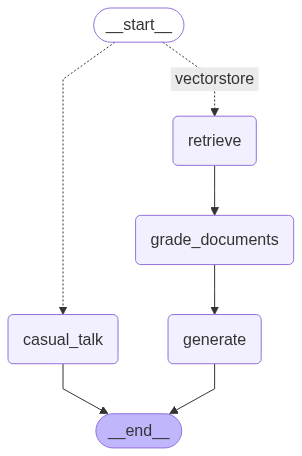

In [28]:
# 그래프 도식화하기
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception: 
    pass

#### 멀티에이전트 테스트하기

In [29]:
inputs = {
    "question": "서울시 자율주행 계획"
}

app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to vectorstore---
------RETRIEVE------
------GRADE------
------GENERATE------


{'question': '서울시 자율주행 계획',
 'generation': AIMessage(content='서울시의 자율주행 계획은 2030년까지 간선도로급 이상의 도로에서 자율주행 자동차의 운행 환경을 조성하고, 2040년까지 서울 전역에서 자율주행차량 운행 환경을 구축하는 것을 목표로 하고 있습니다. 이 계획은 미래 교통수단의 도입에 따른 도시의 변화에 대응하기 위한 것으로, 자율주행이 가장 가시화된 미래 교통기술로 자리잡고 있다는 점에 주목하고 있습니다.\n\n구체적으로, 서울시는 2040년까지 자율주행차량의 수송 분담률을 10%까지 끌어올리는 것을 목표로 하고 있으며, 도심 항공교통(UAM) 기반 시설도 확충할 예정입니다. 이를 위해 도심과 김포공항을 연결하는 시범노선을 운영하고, 한강과 주요 수변 공간을 중심으로 광역노선을 개발하는 계획도 포함되어 있습니다. 또한, 서울 전역에 모빌리티 허브를 구축하여 미래 교통과 기존 교통의 연계를 강화하고 다양한 기능이 복합적으로 제공되는 지역 거점을 마련할 예정입니다.\n\n이러한 계획은 서울의 미래 교통 환경을 선제적으로 준비하고, 안전하고 효율적인 교통체계 구축을 위한 도시 인프라의 확충을 목표로 하고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 295, 'prompt_tokens': 1481, 'total_tokens': 1776, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'sy

In [30]:
inputs = {
    "question": "잘 지내고 있어?"
}

app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to casual_talk---
------CASUAL TALK------


{'question': '잘 지내고 있어?',
 'generation': AIMessage(content='네, 잘 지내고 있습니다! 당신은 어떻게 지내고 계신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 13, 'total_tokens': 32, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-C5B65JzQWQnTzHyPunarueiVHLgXR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ee52329c-adb7-4f24-9db7-5274cb646327-0', usage_metadata={'input_tokens': 13, 'output_tokens': 19, 'total_tokens': 32, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}